# Solve logistic ODE with one shot transfer learning

- Loss: somme(residual+) - somme(residual-)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# imports
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy.integrate import solve_ivp

# Add parent directory to sys.path
from pathlib import Path
current_path = Path.cwd()
parent_dir = current_path.parent.parent
sys.path.append(str(parent_dir))

# Import necessary modules
from src.utils_plot import plot_loss_and_all_solution_non_linear, plot_transfer_learned_and_analytical_non_linear, plot_head_loss
from src.load_save import load_run_history
from src.transfer_learning import compute_H_and_dH_dt, analytically_compute_weights

from src.utils_plot import plot_transfer_learned_and_analytical

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [4]:
def check_versions_and_device():
  # set the device to the GPU if it is available, otherwise use the CPU
  current_dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  !nvidia-smi
  return current_dev

# set a global device variable to use in code
dev = check_versions_and_device()
print(dev)

Fri Jan 26 15:38:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   37C    P0              N/A /   5W |      0MiB /  2048MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
num_heads = 12
equation_name = "Logistic"

def ODE(t, y, alpha):
   return alpha*y[..., 0]*(1-y[..., 0])

np.random.seed(42)

alpha_bounds = (1, 5)
def generate_alpha(k, alpha_bounds = alpha_bounds):
  alpha_list = np.zeros(k)
  for i in range(k):
    alpha_list[i] = np.random.uniform(alpha_bounds[0], alpha_bounds[1])
  return alpha_list
alpha_list = generate_alpha(num_heads)

equation_list = [lambda t, y, alpha=alpha: ODE(t, y, alpha=alpha) for alpha in alpha_list]

# training IC (random or not)
def random_IC(x_bound=[1.5, 2.5], y_bound=[0, 0]):
    ICx = np.random.uniform(x_bound[0], x_bound[1], 1)
    ICy = np.random.uniform(y_bound[0], y_bound[1], 1)
    return torch.tensor([ICx, ICy], device=dev)
#IC_list = [random_IC() for i in range(num_heads)]
IC_list = [torch.tensor([2.], device=dev).double() for _ in range(num_heads)]

In [24]:
from src.loss import compute_derivative
import torch.nn as nn

def calc_loss_non_linear(x, equation_list, IC_list, model, true_functs, device):
    # dictionary to store loss results for plotting
    loss_dict = {}

    # compute the PINNS solution
    model_result = lambda t: model(t)[0]
    u_results = model_result(x)

    # compute du/dt
    num_u_vectors = u_results.shape[2]
    du_dt = []
    for i in range(u_results.shape[1]):
        du_dt.append(compute_derivative(u_results[:, i, :].unsqueeze(dim=-1), x, num_u_vectors))
    if IC_list[0].shape[0] == 1:
        du_dt = torch.stack(du_dt, dim=1).squeeze(-1)
    else:
        du_dt = torch.stack(du_dt, dim=1).squeeze()

    # Compute ODE loss
    equations_result = torch.stack([eq(x, u_results[:, i, :]) for i, eq in enumerate(equation_list)], dim=1)
    if equations_result.dim() == 2:
        equations_result = equations_result.unsqueeze(dim=2)

    interior = du_dt - equations_result
    del du_dt, equations_result

    # Compute IC loss
    f_boundary = torch.stack(IC_list)
    u_0 = model_result(torch.tensor([[0]], dtype=torch.float64, device=device))[0]
    boundary = u_0 - f_boundary
    del u_0, f_boundary

    # All together
    loss = nn.MSELoss()
    loss_ODE = 0*loss(interior, torch.zeros_like(interior))
    loss_IC = loss(boundary, torch.zeros_like(boundary))
    total_loss = 0*loss_ODE + loss_IC

    if true_functs is not None:
        loss_error = 0
        for i, func in enumerate(true_functs):
            loss_error += torch.abs(u_results[:, i, :].squeeze() - torch.tensor(func(x.detach().cpu().numpy()).squeeze(), device=device)).mean()
        total_loss +=  loss_error
        loss_dict['L_error'] = loss_error

    loss_dict["head"] = interior.mean(0).mean(1).pow(2) + boundary.mean(1).pow(2)
    loss_dict['L_total'] = total_loss
    loss_dict['L_ODE'] = loss_ODE
    loss_dict['L_IC'] = loss_IC
    return loss_dict

from src.model import BuildNetworkNew
x_range = [0, 10]
activation = "celu"
hid_lay = list(np.array([124, 124, 132]) * 1)
num_equations = 1
model = BuildNetworkNew(1, hid_lay, num_equations, num_heads, activation).to(dev, dtype=torch.double)

# every batch, randomly sample from min and max range
rng = np.random.default_rng()
x = torch.arange(x_range[0], x_range[1], 0.001, requires_grad=True, device=dev).double()
x = x[rng.choice(range(0, len(x)), size=512, replace=False)]
x = x.reshape(-1, 1)
x, _ = x.sort(dim=0)

In [25]:
from collections import defaultdict
import time
from tqdm.auto import trange

from src.model import BuildNetworkNew


# train and evaluate the model
def run_model(iterations, x_range, equation_list, IC_list, hid_lay, activation,
              num_equations, num_heads, sample_size, lr, decay, true_functs=None, verbose=False):
    assert num_equations > 0, 'num_equations must be >= 1'
    assert len(IC_list) == num_heads, 'num_heads must equal the length of v_list'
    assert len(equation_list) == num_heads, 'num_heads must equal the length of A_list'
    assert len(IC_list[0]) == num_equations, 'num_equations does not match equation set-up'
    assert hid_lay[-1] % num_equations == 0, 'last hidden layer does not evenly divide num_equations for transfer learning'

    # build the neural net model
    model = BuildNetworkNew(1, hid_lay, num_equations, num_heads, activation).to(dev, dtype=torch.double)
    # set-up the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # extract the min and max range of x values to sample
    min_x, max_x = x_range

    # create a random number generator for loss computation
    rng = np.random.default_rng()

    # store loss and mse values
    loss_history = defaultdict(list)
    loss_head = []
    start_time = time.time()

    # training loop
    for i in trange(iterations):

        # every batch, randomly sample from min and max range
        x = torch.arange(min_x, max_x, 0.001, requires_grad=True, device=dev).double()
        x = x[rng.choice(range(0, len(x)), size=sample_size, replace=False)]
        x = x.reshape(-1, 1)
        #x += torch.normal(mean=0., std=0.001*torch.ones_like(x))
        x, _ = x.sort(dim=0)

        curr_loss = calc_loss_non_linear(x, equation_list, IC_list, model, true_functs, dev)

        if (verbose) & (i % 200 == 0):
            if true_functs is None:
              print(f"Iterations {i}: loss = {curr_loss['L_total'].item()}, IC_loss = {curr_loss['L_IC']}, ODE_loss = {curr_loss['L_ODE']}")
            else:
              print(f"Iterations {i}: loss = {curr_loss['L_total'].item()}, IC_loss = {curr_loss['L_IC']}, ODE_loss = {curr_loss['L_ODE']}, error_loss = {curr_loss['L_error']}")

        if torch.isnan(curr_loss["L_total"]).item():
          print(f"Training stop after {i} because of diverge loss")
          end_time = time.time()
          total_time = end_time - start_time
          return loss_history, model, total_time

        # store individual loss terms for plotting
        loss_head.append(curr_loss["head"].detach())
        loss_history['L_total'].append(curr_loss['L_total'].detach().item())

        # backward: backpropagation
        curr_loss['L_total'].backward()

        if decay:
          gamma = 0.98  # Adjust the decay factor accordingly
          every = 100  # Adjust the decay interval accordingly
          for param in model.parameters():
              param.grad *= (gamma**((i + 1) / every))

        # update weights and reset the gradients
        optimizer.step()
        optimizer.zero_grad()

    # Stack all head loss
    loss_history["head"] = torch.stack(loss_head, dim=0).cpu().numpy()

    # Compute time
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Model Training Complete in{total_time: .3f} seconds")

    return loss_history, model, total_time

In [29]:
x_range = [0, 2]
activation = "celu"
hid_lay = list(np.array([124, 124, 132]) * 1)
#hid_lay = list(np.array([128, 128, 256, 512]) * 1)
num_equations = 1
iterations = 10000


numerical_sol_fct = lambda x, v, equation: (solve_ivp(equation, [x_range[0], x_range[1]],
                                                      v, t_eval=x.squeeze()).y)

numerical_sol_fct_list = [lambda x, v=IC.detach().cpu().numpy(), equation=eq: numerical_sol_fct(x, v, equation) for IC, eq in zip(IC_list, equation_list)]

loss_history, model, total_time = run_model(iterations=iterations, x_range=x_range, equation_list=equation_list,
                                            IC_list=IC_list, hid_lay=hid_lay, activation=activation,
                                            num_equations=num_equations, num_heads=num_heads, sample_size=512,
                                            lr=0.001, decay=True, true_functs=numerical_sol_fct_list, verbose=True)   

  0%|          | 0/10000 [00:00<?, ?it/s]

Iterations 0: loss = 17.772173694706083, IC_loss = 4.013155258869331, ODE_loss = 0.0, error_loss = 13.759018435836753
Iterations 200: loss = 0.33979092458473825, IC_loss = 0.01954917903756649, ODE_loss = 0.0, error_loss = 0.3202417455471718
Iterations 400: loss = 0.16689847312701667, IC_loss = 0.007886657650733098, ODE_loss = 0.0, error_loss = 0.15901181547628357
Iterations 600: loss = 0.17059073412510337, IC_loss = 0.003465966133382255, ODE_loss = 0.0, error_loss = 0.1671247679917211
Iterations 800: loss = 0.14529543006025428, IC_loss = 0.0033119618447498924, ODE_loss = 0.0, error_loss = 0.1419834682155044
Iterations 1000: loss = 0.197426093909503, IC_loss = 0.0038953754091362357, ODE_loss = 0.0, error_loss = 0.19353071850036677
Iterations 1200: loss = 0.14010642827492384, IC_loss = 0.0021241171375369974, ODE_loss = 0.0, error_loss = 0.13798231113738685
Iterations 1400: loss = 0.05788550309624804, IC_loss = 0.0008851230450714891, ODE_loss = 0.0, error_loss = 0.05700038005117655
Iterat

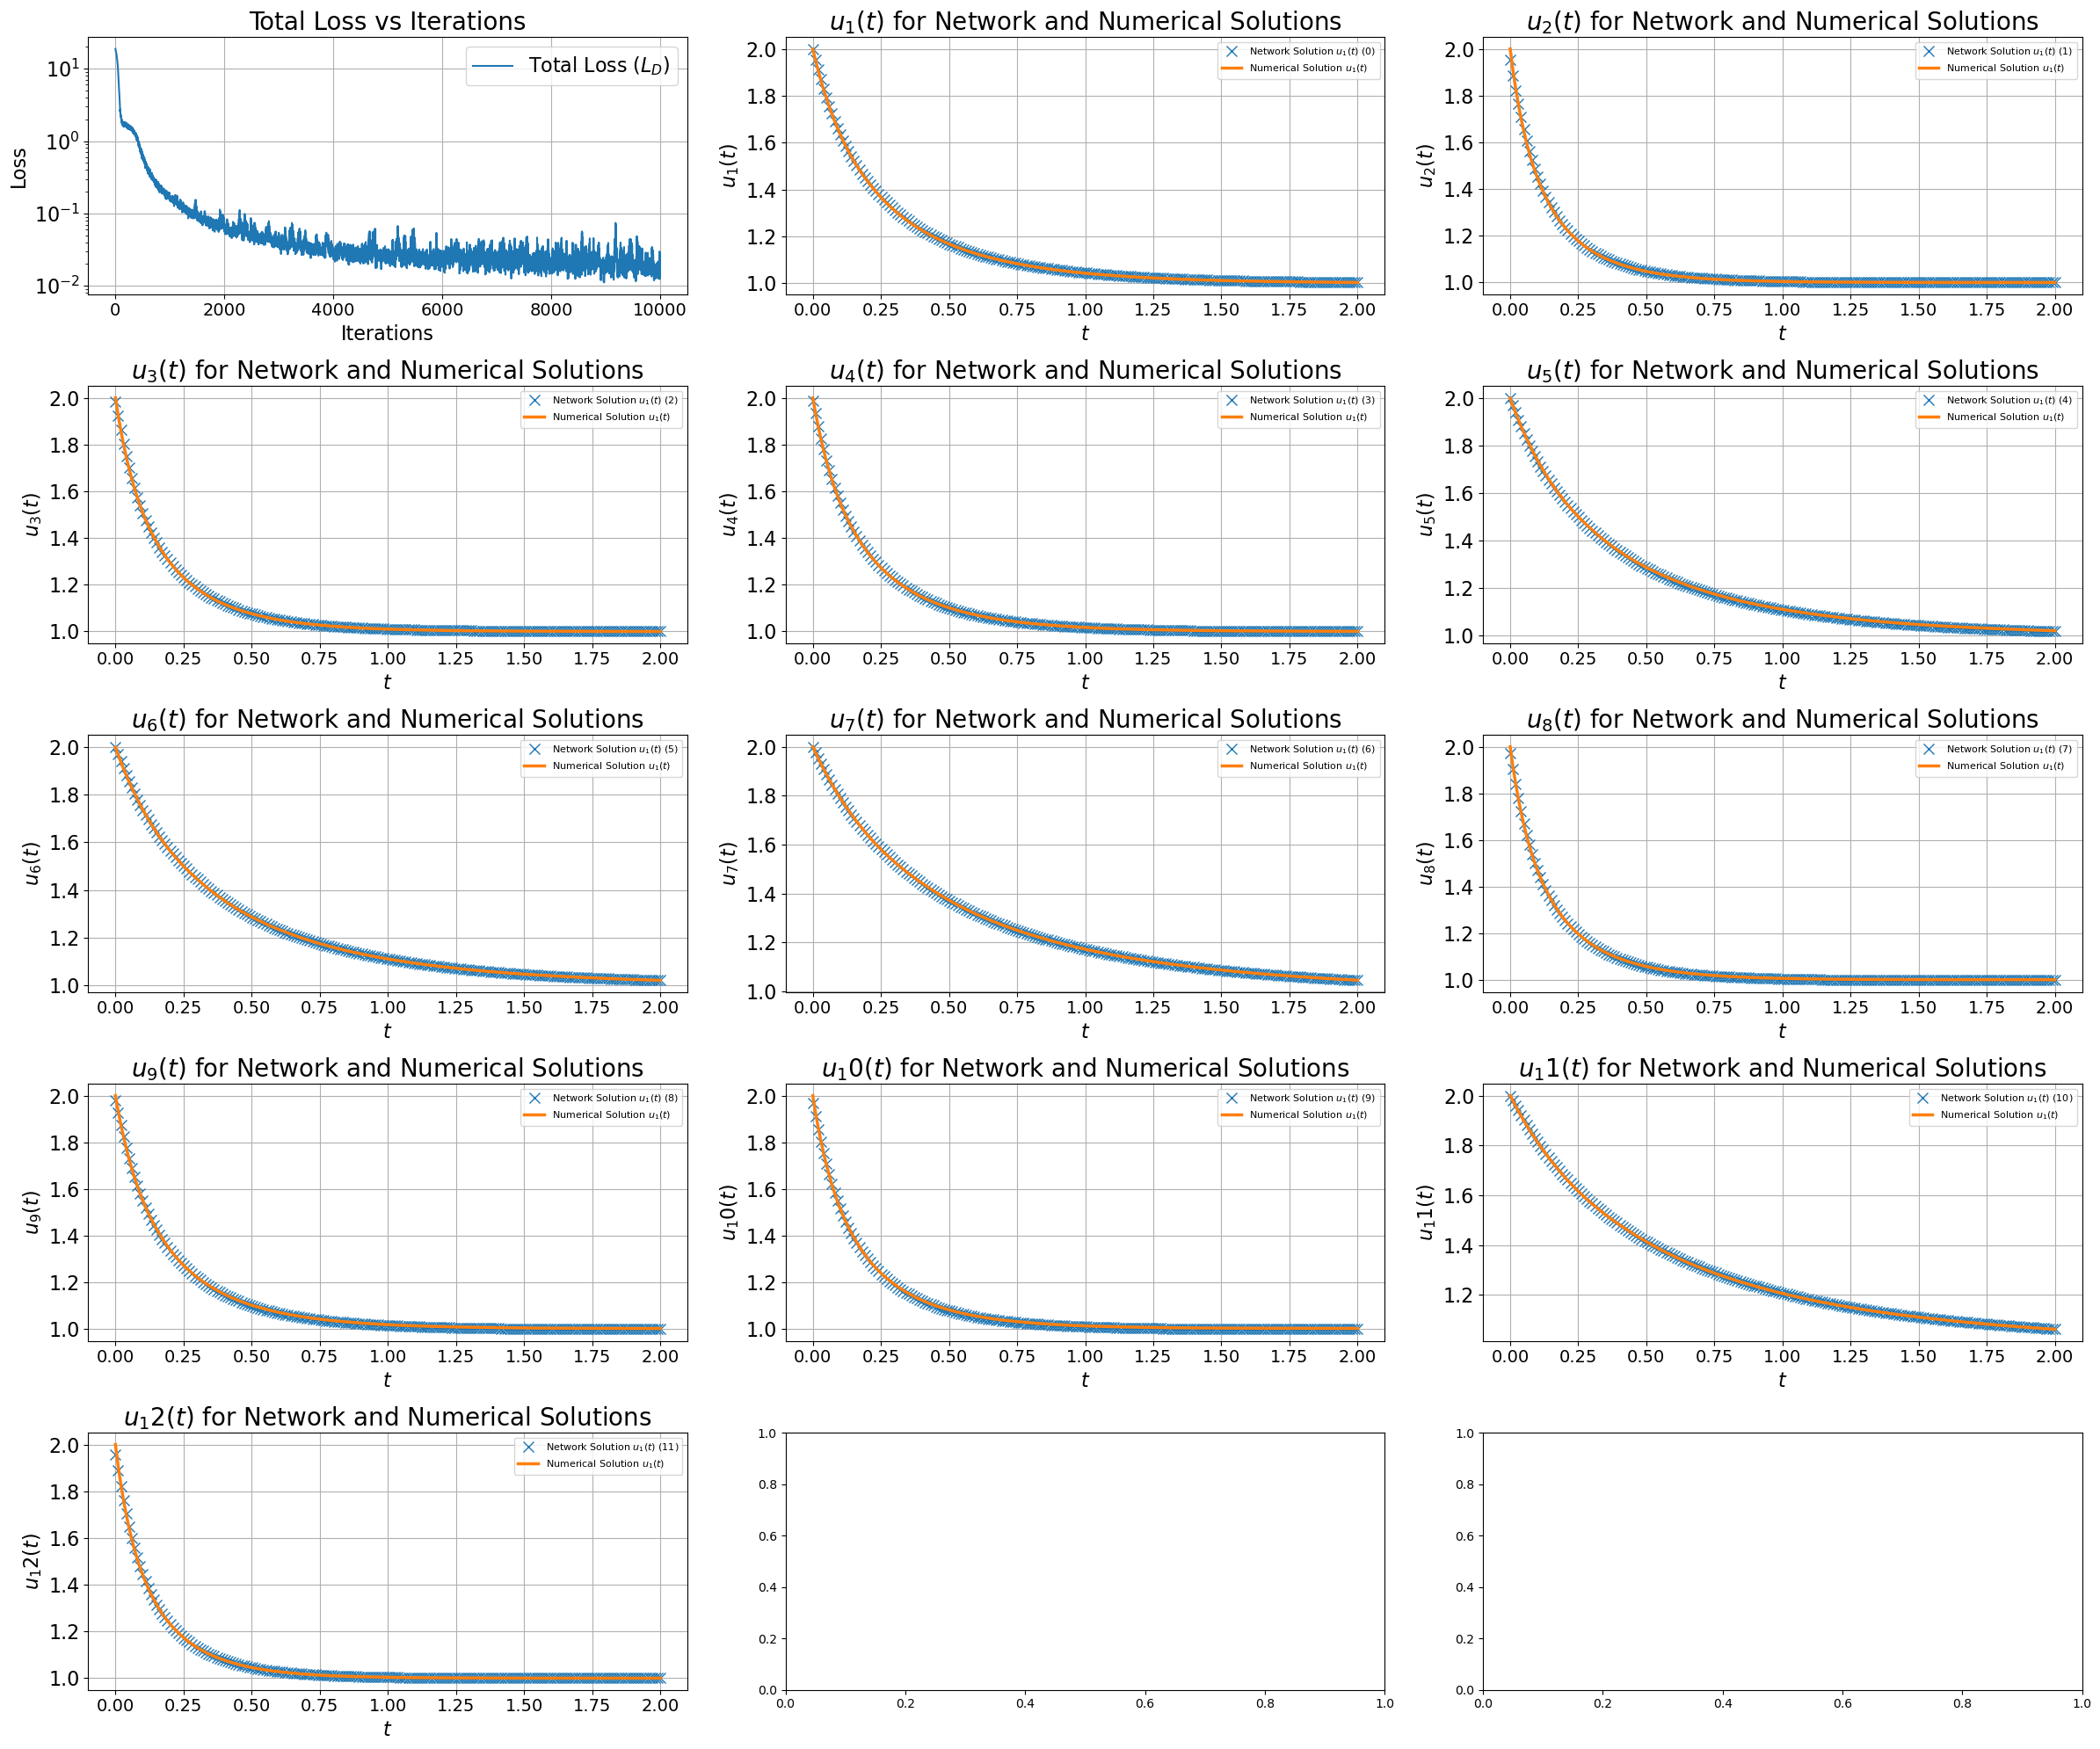

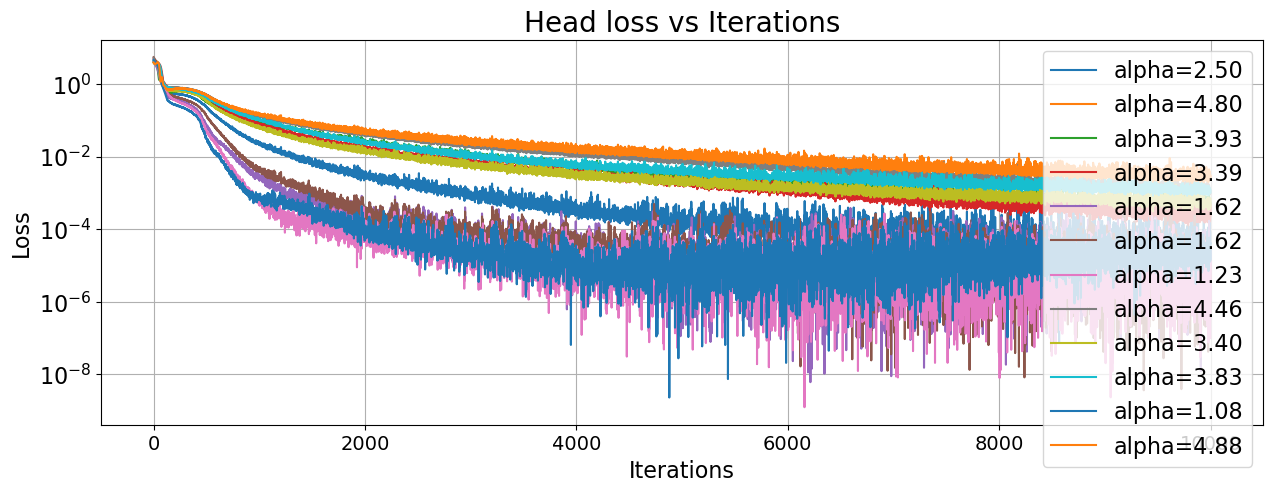

In [28]:
plot_loss_and_all_solution_non_linear(x_range=x_range, true_funct=numerical_sol_fct,
                                      trained_model=model, IC_list=IC_list,
                                      equation_list=equation_list, train_losses=loss_history['L_total'],
                                      loss_label='Total Loss ($L_D$)',
                                      device=dev)

plot_head_loss(loss_history["head"], alpha_list)

# Transfer learning

In [12]:
from src.transfer_learning import compute_H_and_dH_dt
H, H_0, dH_dt, t_eval = compute_H_and_dH_dt(x_range[0], x_range[1], model, num_equations, hid_lay, 512, dev)

Time to compute H and dH_dt:  0.468 seconds


In [13]:
def isPSD(A, tol=1e-8):
    E, _ = np.linalg.eigh(A)
    return np.all(E >= -tol)

def isNSD(A, tol=1e-8):
    E, _ = np.linalg.eigh(A)
    return np.all(E <= -tol)

t_psd_nsd = []
for i in range(H.shape[0]):
    h = H[i, ...]
    Hessian = h.T@h
    if isPSD(Hessian.detach().cpu().numpy()):
        t_psd_nsd.append(1)
    elif isNSD(Hessian.detach().cpu().numpy()):
        t_psd_nsd.append(-1)
    else:
        t_psd_nsd.append(0)

In [60]:
def analytically_compute_weights_Logistic(dH_dt, H, H_0, t_eval, IC, alpha, ind_neg=None):

    if ind_neg is not None:
        if isinstance(ind_neg, list):
            for val, i in enumerate(ind_neg):
                if val==1:
                   H[i, ...] = -H[i, ...] 
        else:
            H[ind_neg, ...] = -H[ind_neg, ...]

    # matrix M
    M_sum_terms = alpha*H.mT@H 
    M_sum_terms = M_sum_terms.sum(axis=0)
    M_sum_terms = M_sum_terms / len(t_eval)

    M_H0_term = H_0.mT@H_0

    M = M_sum_terms + M_H0_term
    M_inv = torch.linalg.pinv(M)

    # W_out
    H_term = dH_dt.mT - alpha*H.mT
    H_term = H_term.sum(axis=0)
    H_term = H_term / len(t_eval)

    H0_term = H_0.T@IC

    all_term = H0_term - 0.5*H_term.squeeze()

    W_out = M_inv@all_term

    return M_inv, W_out, _, _

In [65]:
# choose an initial condition and set of coefficients that were trained on
alpha_transfer = 2
IC_transfer = IC_list[0]
equation_transfer = lambda t, y, alpha=alpha_transfer: ODE(t, y, alpha=alpha)

M_inv, W_out, force_terms, total_time = analytically_compute_weights_Logistic(dH_dt,
                                                                              H, H_0,
                                                                              t_eval,
                                                                              IC_transfer,
                                                                              alpha_transfer)
u_ref = torch.matmul(H.double(), W_out.double()).squeeze().detach().cpu().numpy()
true = numerical_sol_fct(t_eval.detach().cpu().numpy(), IC_transfer.detach().cpu().numpy(), equation_transfer).squeeze()
error_ref = np.abs(u_ref-true)

neg_list = []
for i in trange(H.shape[0]):
    _, W_out_i, _, _ = analytically_compute_weights_Logistic(dH_dt,
                                                             H, H_0,
                                                             t_eval,
                                                             IC_transfer,
                                                             alpha_transfer,
                                                             ind_neg=i)
    u_i = torch.matmul(H.double(), W_out_i.double()).squeeze().detach().cpu().numpy()
    error = np.abs(u_i-true)
    if error[i]<error_ref[i]:
        neg_list.append(1)
    else:
        neg_list.append(0)
    

  0%|          | 0/512 [00:00<?, ?it/s]

17424

In [69]:
# choose an initial condition and set of coefficients that were trained on
alpha_transfer = 2
IC_transfer = IC_list[0]
equation_transfer = lambda t, y, alpha=alpha_transfer: ODE(t, y, alpha=alpha)

M_inv, W_out, force_terms, total_time = analytically_compute_weights_Logistic(dH_dt,
                                                                              H, H_0,
                                                                              t_eval,
                                                                              IC_transfer,
                                                                              alpha_transfer,
                                                                              ind_neg=neg_list)

In [67]:
# # choose an initial condition and set of coefficients that were trained on
# alpha_transfer = 2
# IC_transfer = IC_list[0]
# equation_transfer = lambda t, y, alpha=alpha_transfer: ODE(t, y, alpha=alpha)

# M_inv, W_out, force_terms, total_time = analytically_compute_weights_Logistic(dH_dt,
#                                                                               H, H_0,
#                                                                               t_eval,
#                                                                               IC_transfer,
#                                                                               alpha_transfer)

mean 1.1185612642212042
max 6.511811406445646


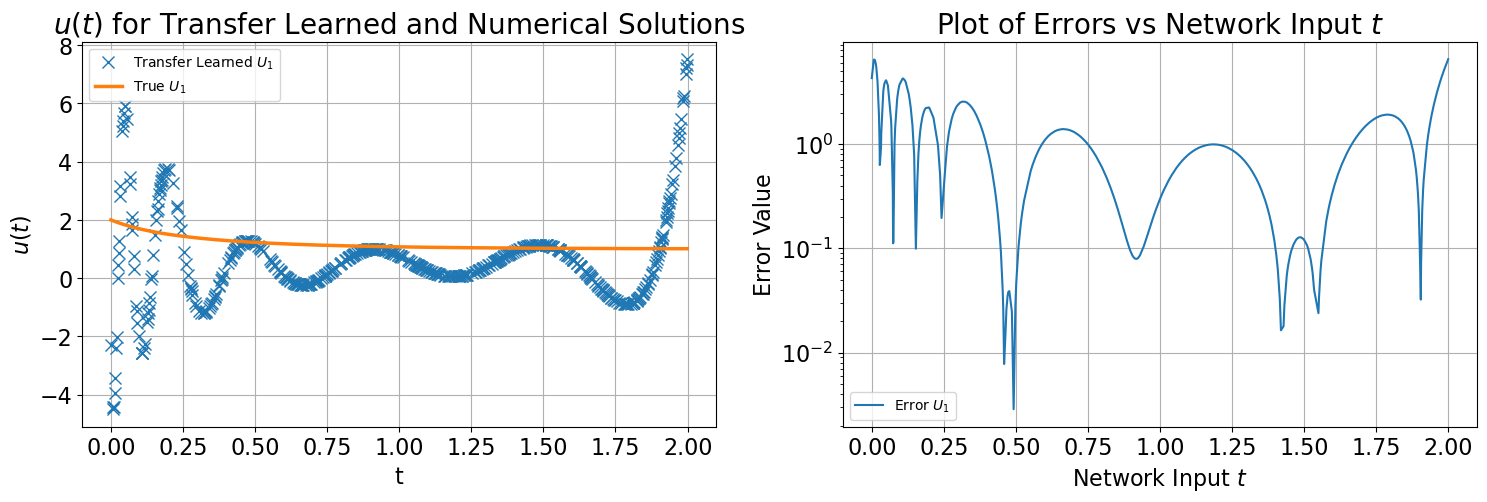

In [68]:
def plot_transfer_learned_and_analytical(H, W_out, t_eval, IC, equation, num_equations, true_funct):

    fig, axs = plt.subplots(1, 2, tight_layout=False, figsize=(18, 5))

    # compute the transfer learned solution
    u_transfer = torch.matmul(H.double(), W_out.double())

    #plot the transfer learned solutions
    for i in range(num_equations):
        axs[0].plot(t_eval.detach().cpu().numpy(),
                    u_transfer[:, i, :].detach().cpu().numpy() if len(u_transfer.shape) == 3 else u_transfer[:, i].detach().cpu().numpy(),
                    'x', markersize=8, label=f'Transfer Learned $U_{{{i+1}}}$', linewidth=3.5)

    # plot the true solutions
    for i in range(num_equations):
        axs[0].plot(t_eval.detach().cpu().numpy(),
                    true_funct(t_eval.detach().cpu().numpy(), IC.detach().cpu().numpy(), equation)[i],
                    label=f'True $U_{{{i+1}}}$', linewidth=2.5)

    axs[0].set_title("$u(t)$ for Transfer Learned and Numerical Solutions", fontsize=20)
    axs[0].set_xlabel("t", fontsize=16)
    axs[0].set_ylabel("$u(t)$", fontsize=16)
    axs[0].tick_params(axis='x', labelsize=16)
    axs[0].tick_params(axis='y', labelsize=16)
    axs[0].grid()
    axs[0].legend()

    # plot the transfer learned solutions
    for i in range(num_equations):
        predicted_vals = u_transfer[:, i, :].detach().cpu().numpy().squeeze() if len(u_transfer.shape) == 3 else u_transfer[:, i].detach().cpu().numpy().squeeze(),
        true_vals = true_funct(t_eval.detach().cpu().numpy(), IC.detach().cpu().numpy(), equation)[i]

        error = np.abs((predicted_vals - true_vals))
        print(f"mean {error.mean()}")
        print(f"max {error.max()}")
        axs[1].plot(t_eval.detach().cpu().numpy().squeeze(), error.squeeze(), label=f'Error $U_{{{i+1}}}$')

    axs[1].set_title("Plot of Errors vs Network Input $t$", fontsize=20)
    axs[1].set_xlabel("Network Input $t$", fontsize=16)
    axs[1].set_yscale('log')
    axs[1].set_ylabel('Error Value', fontsize=16)
    axs[1].tick_params(axis='x', labelsize=16)
    axs[1].tick_params(axis='y', labelsize=16)
    axs[1].grid()
    axs[1].legend()

plot_transfer_learned_and_analytical(H, W_out, t_eval, IC_transfer, equation_transfer, num_equations, numerical_sol_fct)

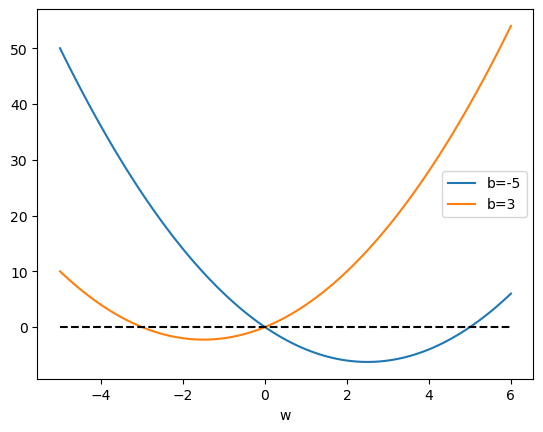

In [27]:
a_list = [1]
# b_list = [-50, -10, -8, -4, -1, 1, 4, 8, 10, 50]
b_list = [-5, 3]
x = np.linspace(-5, 6, 100)

for a in a_list:
    for b in b_list:
        plt.plot(x, (a*x**2 + b*x), label = f"b={b}")
plt.plot(x, [0 for i in range(len(x))], "k--")
plt.xlabel("w")
plt.legend()

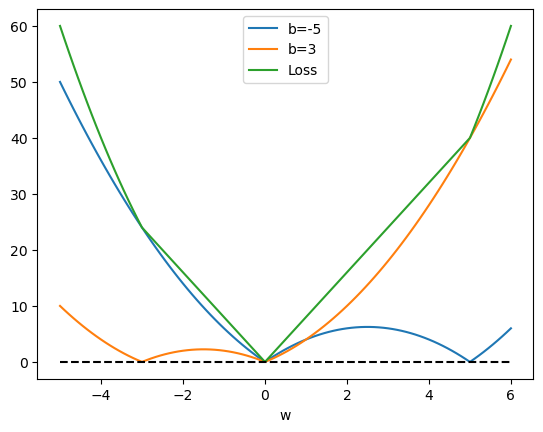

In [34]:
a_list = [1]
# b_list = [-50, -10, -8, -4, -1, 1, 4, 8, 10, 50]
b_list = [-5, 3]
x = np.linspace(-5, 6, 100)
sum_f = 0
for a in a_list:
    for b in b_list:
        plt.plot(x, np.abs((a*x**2 + b*x)), label = f"b={b}")
        sum_f += np.abs((a*x**2 + b*x))
plt.plot(x, sum_f, label="Loss")        
plt.plot(x, [0 for i in range(len(x))], "k--")
plt.xlabel("w")
plt.legend()

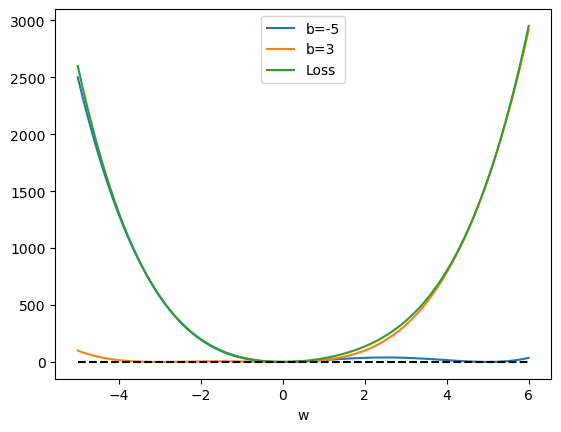

In [37]:
a_list = [1]
# b_list = [-50, -10, -8, -4, -1, 1, 4, 8, 10, 50]
b_list = [-5, 3]
x = np.linspace(-5, 6, 100)
sum_f = 0
for a in a_list:
    for b in b_list:
        plt.plot(x, (a*x**2 + b*x)**2, label = f"b={b}")
        sum_f += (a*x**2 + b*x)**2
plt.plot(x, sum_f, label="Loss")        
plt.plot(x, [0 for i in range(len(x))], "k--")
plt.xlabel("w")
plt.legend()

17424

In [38]:
import scipy

scipy.special.comb(132, 2)

8646.0